<a href="https://colab.research.google.com/github/akshant6/Neural-Style-Transfe/blob/main/Aries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import sys
import scipy.io
import scipy.misc
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from PIL import Image
import numpy as np
import tensorflow as tf
from tensorflow.python.framework.ops import EagerTensor
import pprint
%matplotlib inline

In [2]:
tf.random.set_seed(272)  # DO NOT CHANGE THIS VALUE
pretty_printer = pprint.PrettyPrinter(indent=4)
image_size = 400
vgg_model = tf.keras.applications.VGG19(include_top=False,
                                        input_shape=(image_size, image_size, 3),
                                        weights='imagenet')

vgg_model.trainable = False
pretty_printer.pprint(vgg_model)


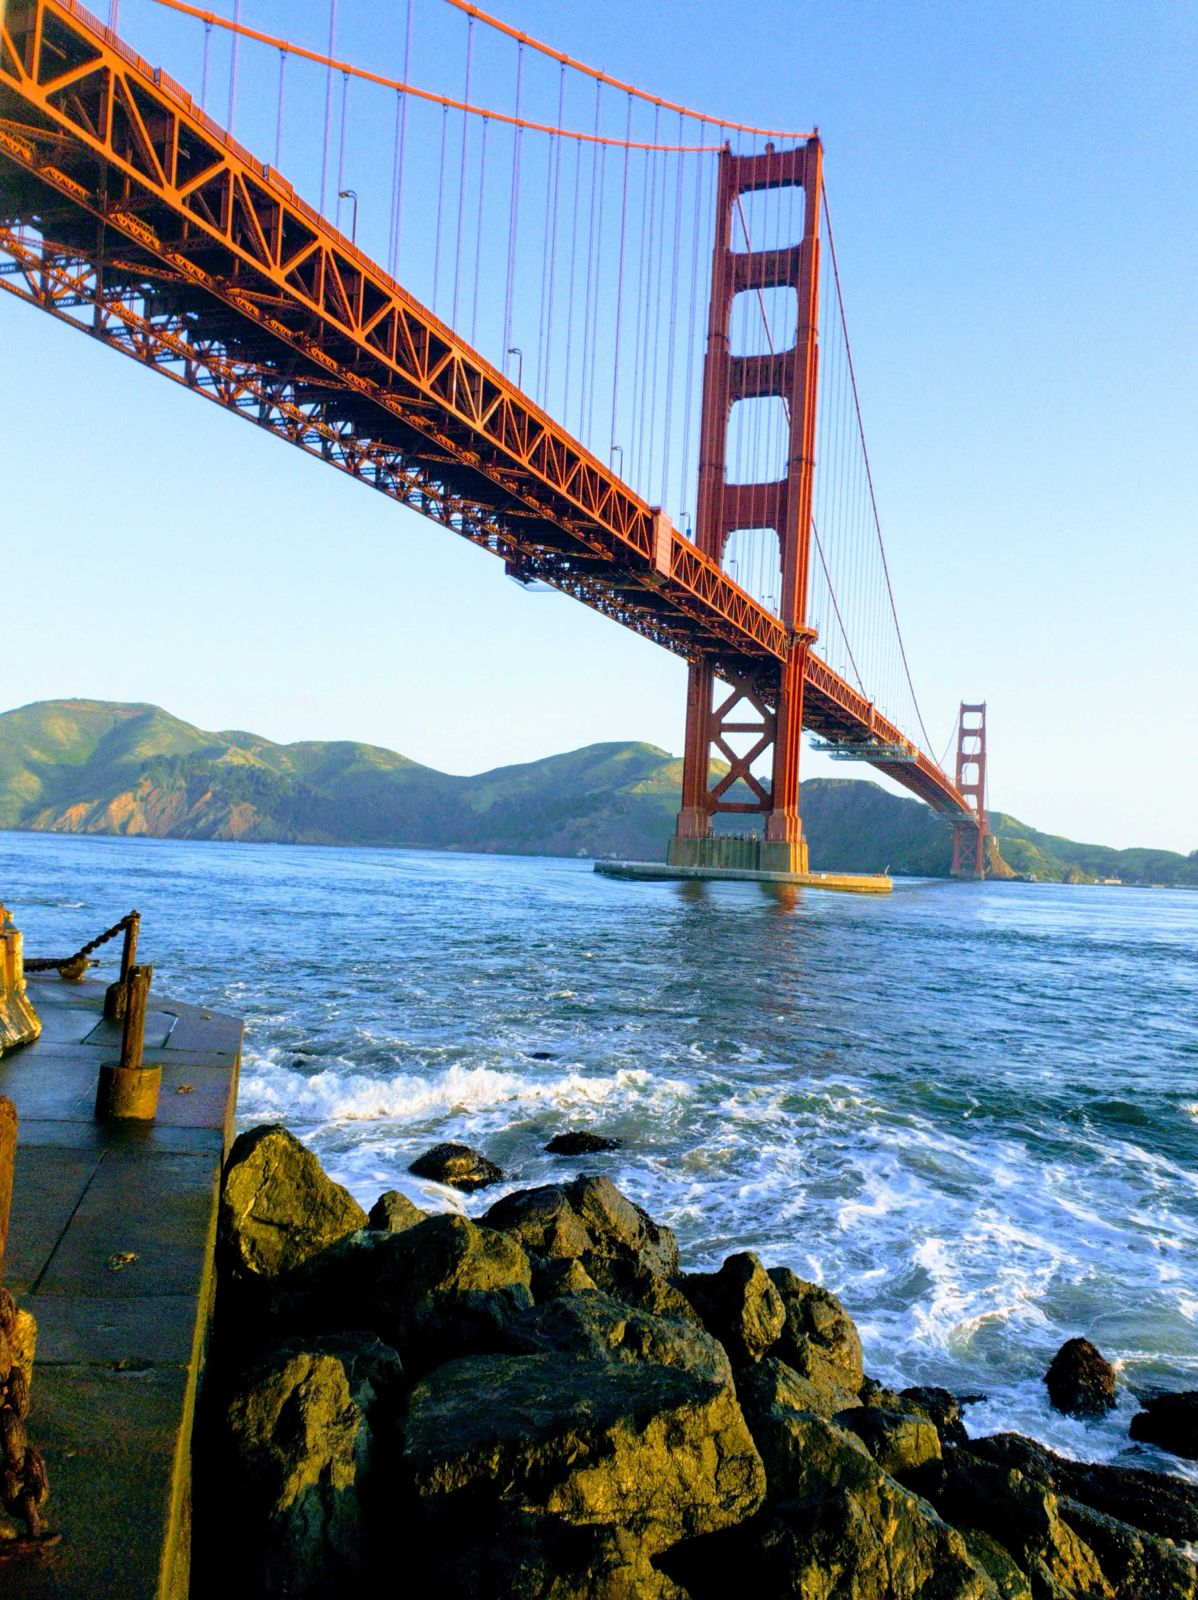

In [3]:
content_image = Image.open("/content/WhatsApp Image 2024-06-20 at 5.35.24 PM.jpeg")

content_image

In [4]:
# UNQ_C1
# GRADED FUNCTION: compute_content_cost

def compute_content_cost(content_output, generated_output):
    """
    Computes the content cost

    Arguments:
    content_output -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing content of the image C
    generated_output -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing content of the image G

    Returns:
    J_content -- scalar that you compute using equation 1 above.
    """
    content_activations = content_output[-1]
    generated_activations = generated_output[-1]

    ### START CODE HERE

    # Retrieve dimensions from generated_activations (≈1 line)
    batch_size, height, width, channels = generated_activations.get_shape().as_list()

    # Reshape content_activations and generated_activations (≈2 lines)
    content_unrolled = tf.transpose(tf.reshape(content_activations, shape=[batch_size, -1, channels]))
    generated_unrolled = tf.transpose(tf.reshape(generated_activations, shape=[batch_size, -1, channels]))

    # compute the cost with tensorflow (≈1 line)
    content_cost = (1 / (4 * height * width * channels)) * tf.reduce_sum(tf.square(tf.subtract(content_unrolled, generated_unrolled)))

    ### END CODE HERE

    return content_cost


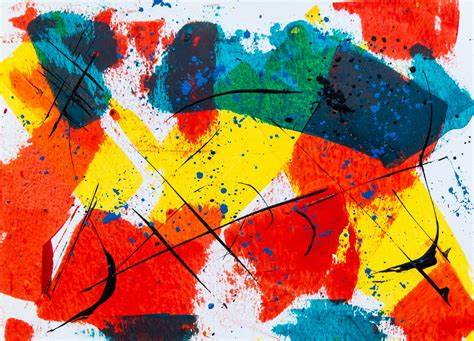

In [5]:
example = Image.open("/content/stylr1.jpeg")
example

In [6]:
# UNQ_C2
# GRADED FUNCTION: gram_matrix

def gram_matrix(matrix):
    """
    Argument:
    matrix -- matrix of shape (channels, height*width)

    Returns:
    gram -- Gram matrix of matrix, of shape (channels, channels)
    """
    ### START CODE HERE
    #(≈1 line)

    gram = tf.matmul(matrix, matrix, transpose_b=True)

    ### END CODE HERE

    return gram


In [7]:
tf.random.set_seed(1)
matrix = tf.random.normal([3, 2 * 1], mean=1, stddev=4)
gram = gram_matrix(matrix)

assert type(gram) == EagerTensor, "Use the tensorflow function"
assert gram.shape == (3, 3), "Wrong shape. Check the order of the matmul parameters"
assert np.allclose(gram[0, :], [63.1888, -26.721275, -7.7320204]), "Wrong values."

print("gram = \n" + str(gram))

print("\033[92mAll tests passed")


gram = 
tf.Tensor(
[[ 63.1888    -26.721275   -7.7320204]
 [-26.721275   12.76758    -2.5158243]
 [ -7.7320204  -2.5158243  23.752384 ]], shape=(3, 3), dtype=float32)
All tests passed


In [8]:
# UNQ_C3
# GRADED FUNCTION: compute_layer_style_cost

def compute_layer_style_cost(style_activations, generated_activations):
    """
    Arguments:
    style_activations -- tensor of dimension (1, height, width, channels), hidden layer activations representing style of the image S
    generated_activations -- tensor of dimension (1, height, width, channels), hidden layer activations representing style of the image G

    Returns:
    style_cost_layer -- tensor representing a scalar value, style cost defined above by equation (2)
    """
    ### START CODE HERE

    # Retrieve dimensions from generated_activations (≈1 line)
    batch_size, height, width, channels = generated_activations.get_shape().as_list()

    # Reshape the images from (height * width, channels) to have them of shape (channels, height * width) (≈2 lines)
    style_activations = tf.transpose(tf.reshape(style_activations, shape=[-1, channels]))
    generated_activations = tf.transpose(tf.reshape(generated_activations, shape=[-1, channels]))

    # Computing gram matrices for both images S and G (≈2 lines)
    gram_style = gram_matrix(style_activations)
    gram_generated = gram_matrix(generated_activations)

    # Computing the loss (≈1 line)
    style_cost_layer = (1 / (4 * channels ** 2 * (height * width) ** 2)) * tf.reduce_sum(tf.square(tf.subtract(gram_style, gram_generated)))

    ### END CODE HERE

    return style_cost_layer


In [9]:
for layer in vgg_model.layers:
    print(layer.name)


input_1
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In [10]:
vgg_model.get_layer('block5_conv4').output


<KerasTensor: shape=(None, 25, 25, 512) dtype=float32 (created by layer 'block5_conv4')>

In [11]:
STYLE_LAYERS = [
    ('block1_conv1', 0.2),
    ('block2_conv1', 0.2),
    ('block3_conv1', 0.2),
    ('block4_conv1', 0.2),
    ('block5_conv1', 0.2)
]

In [12]:
def compute_style_cost(style_output, generated_output, style_layers=STYLE_LAYERS):
    """
    Computes the overall style cost from several chosen layers

    Arguments:
    style_output -- our tensorflow model
    generated_output --
    style_layers -- A python list containing:
                        - the names of the layers we would like to extract style from
                        - a coefficient for each of them

    Returns:
    J_style -- tensor representing a scalar value, style cost defined above by equation (2)
    """

    # initialize the overall style cost
    J_style = 0

    # Set a_S to be the hidden layer activation from the layer we have selected.
    # The last element of the array contains the content layer image, which must not to be used.
    a_S = style_output[:-1]

    # Set a_G to be the output of the chosen hidden layers.
    # The last element of the array contains the content layer image, which must not to be used.
    a_G = generated_output[:-1]
    for i, weight in zip(range(len(a_S)), style_layers):
        # Compute style_cost for the current layer
        J_style_layer = compute_layer_style_cost(a_S[i], a_G[i])

        # Add weight * J_style_layer of this layer to overall style cost
        J_style += weight[1] * J_style_layer

    return J_style


In [13]:
@tf.function()
def total_cost(content_cost, style_cost, alpha=10, beta=40):
    """
    Computes the total cost function

    Arguments:
    content_cost -- content cost coded above
    style_cost -- style cost coded above
    alpha -- hyperparameter weighting the importance of the content cost
    beta -- hyperparameter weighting the importance of the style cost

    Returns:
    total_cost -- total cost as defined by the formula above.
    """
    ### START CODE HERE

    total_cost = alpha * content_cost + beta * style_cost

    ### END CODE HERE

    return total_cost


In [14]:
content_cost = 0.2
style_cost = 0.8
J = total_cost(content_cost, style_cost)

assert type(J) == EagerTensor, "Do not remove the @tf.function() modifier from the function"
assert J == 34, "Wrong value. Try inverting the order of alpha and beta in the J calculation"
assert np.isclose(total_cost(0.3, 0.5, 3, 8), 4.9), "Wrong value. Use the alpha and beta parameters"

np.random.seed(1)
print("J = " + str(total_cost(np.random.uniform(0, 1), np.random.uniform(0, 1))))

print("\033[92mAll tests passed")


J = tf.Tensor(32.9832, shape=(), dtype=float32)
All tests passed


(1, 400, 400, 3)


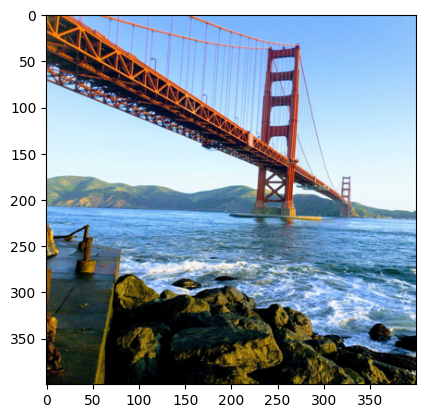

In [15]:
content_img = np.array(Image.open("/content/WhatsApp Image 2024-06-20 at 5.35.24 PM.jpeg").resize((image_size, image_size)))
content_img = tf.constant(np.reshape(content_img, ((1,) + content_img.shape)))

print(content_img.shape)
imshow(content_img[0])
plt.show()


(1, 400, 400, 3)


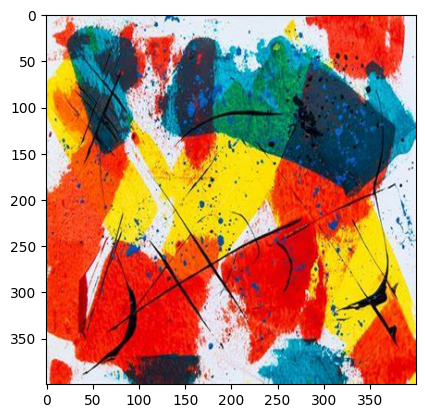

In [16]:
style_img = np.array(Image.open("/content/stylr1.jpeg").resize((image_size, image_size)))
style_img = tf.constant(np.reshape(style_img, ((1,) + style_img.shape)))

print(style_img.shape)
imshow(style_img[0])
plt.show()


(1, 400, 400, 3)


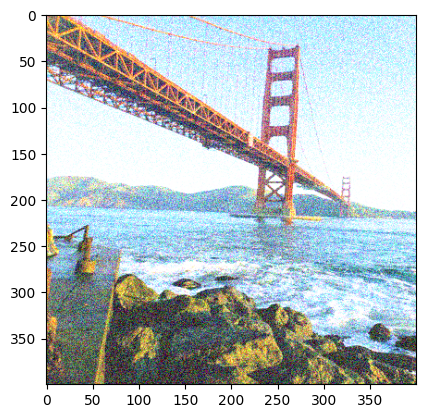

In [17]:
generated_img = tf.Variable(tf.image.convert_image_dtype(content_img, tf.float32))
noise = tf.random.uniform(tf.shape(generated_img), 0, 0.5)
generated_img = tf.add(generated_img, noise)
generated_img = tf.clip_by_value(generated_img, clip_value_min=0.0, clip_value_max=1.0)

print(generated_img.shape)
imshow(generated_img.numpy()[0])
plt.show()


In [18]:
def get_layer_outputs(vgg_model, layer_names):
    """ Creates a vgg model that returns a list of intermediate output values."""
    outputs = [vgg_model.get_layer(layer[0]).output for layer in layer_names]

    model = tf.keras.Model([vgg_model.input], outputs)
    return model


In [19]:
content_layer = [('block5_conv4', 1)]

vgg_model_outputs = get_layer_outputs(vgg_model, STYLE_LAYERS + content_layer)


In [20]:
content_target = vgg_model_outputs(content_img)  # Content encoder
style_targets = vgg_model_outputs(style_img)     # Style encoder


In [21]:
# Assign the content image to be the input of the VGG model.
# Set a_C to be the hidden layer activation from the layer we have selected
preprocessed_content =  tf.Variable(tf.image.convert_image_dtype(content_img, tf.float32))
a_C = vgg_model_outputs(preprocessed_content)

# Set a_G to be the hidden layer activation from the same layer. Here, a_G references model['conv4_2']
# and isn't evaluated yet. Later in the code, we'll assign the image G as the model input.
a_G = vgg_model_outputs(generated_img)

# Compute the content cost
J_content = compute_content_cost(a_C, a_G)

print(J_content)


tf.Tensor(0.0067556845, shape=(), dtype=float32)


In [22]:
# Assign the input of the model to be the "style" image
preprocessed_style =  tf.Variable(tf.image.convert_image_dtype(style_img, tf.float32))
a_S = vgg_model_outputs(preprocessed_style)

# Compute the style cost
J_style = compute_style_cost(a_S, a_G)
print(J_style)


tf.Tensor(627.8148, shape=(), dtype=float32)


In [23]:
def clip_0_1(image):
    """
    Truncate all the pixels in the tensor to be between 0 and 1

    Arguments:
    image -- Tensor

    Returns:
    Tensor
    """
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

def tensor_to_image(tensor):
    """
    Converts the given tensor into a PIL image

    Arguments:
    tensor -- Tensor

    Returns:
    Image: A PIL image
    """
    tensor = tensor * 255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor) > 3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return Image.fromarray(tensor)


In [25]:
from tqdm import tqdm

  0%|          | 0/2501 [00:00<?, ?it/s]

Epoch 0 


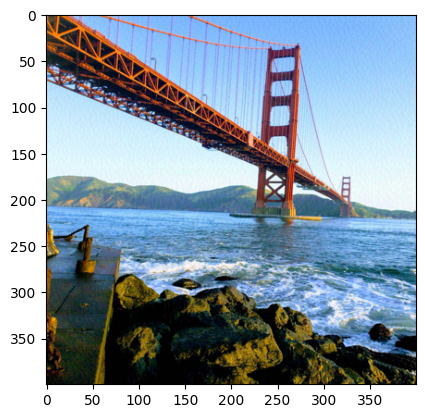

 10%|▉         | 250/2501 [25:15<3:40:01,  5.86s/it]

Epoch 250 


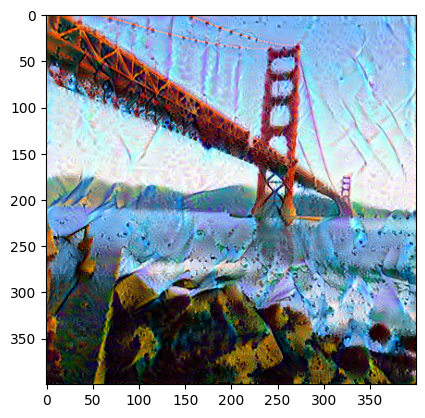

 17%|█▋        | 413/2501 [41:29<3:25:24,  5.90s/it]

In [ ]:
# Ensure generated_img is trainable when creating it
generated_img = tf.Variable(tf.image.convert_image_dtype(content_img, tf.float32), trainable=True)

# Define the optimizer here
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01) # You can choose a different optimizer or learning rate if needed

@tf.function()
def train_step(generated_img):
    with tf.GradientTape() as tape:
        # Compute a_G as the vgg_model_outputs for the current generated image
        a_G = vgg_model_outputs(generated_img)

        # Compute the style cost and content cost using appropriate functions
        J_style = compute_style_cost(a_S, a_G)
        J_content = compute_content_cost(a_C, a_G)
        J = total_cost(J_content, J_style)  # Compute total cost

    # Compute gradients and apply them to the trainable variable
    grad = tape.gradient(J, generated_img)
    optimizer.apply_gradients([(grad, generated_img)]) # Now you can use the optimizer

    # Clip generated_img between 0 and 1
    generated_img.assign(clip_0_1(generated_img))

    return J

# Training loop
epochs = 2501
for i in tqdm(range(epochs)):
    train_step(generated_img)
    if i % 250 == 0:
        print(f"Epoch {i} ")
        image = tensor_to_image(generated_img)
        imshow(image)
        plt.show()